In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import rioxarray
import xarray as xr
import rasterio as rio
import glob
import datetime
import geopandas as gpd
from datetime import timedelta
from scipy.optimize import curve_fit

In [2]:
# functions to load interferogram tifs to xarray
def xr_read_geotif(geotif_file_path, masked=True):
    """
    Reads in single or multi-band GeoTIFF as dask array.
    Inputs
    ----------
    GeoTIFF_file_path : GeoTIFF file path
    Returns
    -------
    ds : xarray.Dataset
        Includes rioxarray extension to xarray.Dataset
    """

    da = rioxarray.open_rasterio(geotif_file_path, masked=True)

    # Extract bands and assign as variables in xr.Dataset()
    ds = xr.Dataset()
    for i, v in enumerate(da.band):
        da_tmp = da.sel(band=v)
        da_tmp.name = "band" + str(i + 1)

        ds[da_tmp.name] = da_tmp

    # Delete empty band coordinates.
    # Need to preserve spatial_ref coordinate, even though it appears empty.
    # See spatial_ref attributes under ds.coords.variables used by rioxarray extension.
    del ds.coords["band"]

    # Preserve top-level attributes and extract single value from value iterables e.g. (1,) --> 1
    ds.attrs = da.attrs
    for key, value in ds.attrs.items():
        try:
            if len(value) == 1:
                ds.attrs[key] = value[0]
        except TypeError:
            pass

    return ds

def hyp3_to_xarray(hyp3_dir, file_type='rng_off_phonyunw_aoi', epsg=32645, interpolate_na=False):
    
    dirs = os.listdir(hyp3_dir) #list generated interferograms
    datasets = []
    
    for idir in dirs:
        tif_path = glob.glob(f'{hyp3_dir}/{idir}/*/*{file_type}.tif')[0]
        tif_fn = os.path.split(tif_path)[-1]
        dates = f'{tif_fn[14:22]}_{tif_fn[23:31]}' #parse filename for interferogram dates
        start_date = datetime.datetime.strptime(dates[:8], '%Y%m%d')
        end_date = datetime.datetime.strptime(dates[-8:], '%Y%m%d')
        t_baseline = end_date - start_date
        
        src = xr_read_geotif(tif_path, masked=False) #read product to xarray ds
        src = src.assign_coords({"dates": dates})
        src = src.expand_dims("dates")
        
        src = src.assign_coords(start_date = ('dates', [start_date]))
        src = src.assign_coords(end_date = ('dates', [end_date]))
        src = src.assign_coords(t_baseline = ('dates', [t_baseline]))
        
        src = src.rename({'band1':file_type})
        src = src.rio.write_crs(epsg)
        # in future, should get spatial baseline, flight dir, and orbit from metadata
        
        if interpolate_na == True:
            src = src.interpolate_na(dim='x', method='linear').fillna(value=0)
        
        datasets.append(src)
       
    ds = xr.concat(datasets, dim="dates", combine_attrs="no_conflicts") #create dataset
    return ds 

In [ ]:
# open ints and dems
hyp3_dir = './data/hidden_data_offsets'
offset_ds = hyp3_to_xarray(hyp3_dir)

## SNR stacks

### offset stacks for inversion

In [4]:
# mask nodata
offset_da = xr.where(offset_ds.rng_off_phonyunw_aoi < -5000000, np.nan, offset_ds.rng_off_phonyunw_aoi)

In [6]:
# broadcast t_baselines to offset extent and mask 
ones = xr.ones_like(offset_da)
ones_masked = xr.where(offset_da.isnull(), 0, ones)
t_baseline_broadcast = ones_masked*offset_da.t_baseline.dt.days

In [7]:
mean_offset_per_day = offset_da.sum(dim='dates')/t_baseline_broadcast.sum(dim='dates')

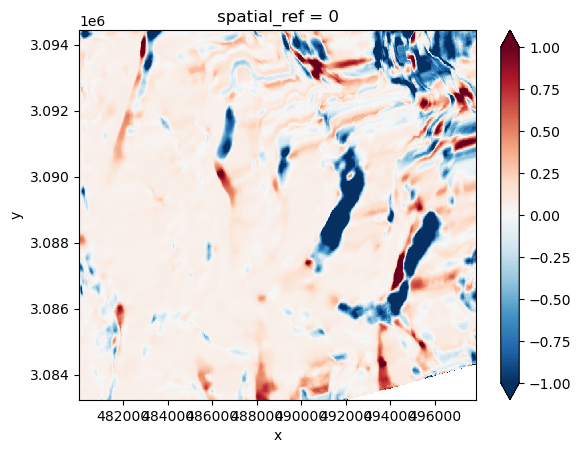

In [9]:
f, ax = plt.subplots()
mean_offset_per_day.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r')

In [10]:
full_t_baseline = offset_da.end_date[-1] - offset_da.start_date[0]

In [14]:
# scale to full temporal baseline
full_displacement = mean_offset_per_day*full_t_baseline.dt.days

In [16]:
# write crs, nodata, convert type
full_displacement = full_displacement.astype(np.float32)
crs = 32645
full_displacement  = full_displacement.rio.write_nodata(0, inplace=True)
full_displacement  = full_displacement .rio.write_crs(crs)

In [ ]:
# create phony coherence and connected components

In [18]:
# write out to raster
# date1 = offset_da.start_date[0].dt.strftime('%Y%m%d').item()
# date2 = offset_da.end_date[-1].dt.strftime('%Y%m%d').item()
full_displacement.rio.to_raster(f'./data/data_stacks/20170123_20240123/S1_023790_IW1_20170123_20240123_VV_INT20_964C/S1_023790_IW1_20170123_20240123_VV_INT20_964C_rng_off_phonyunw_phase_aoi.tif')

In [ ]:
# # Function to fit a sine wave
# def sine_function(t, amplitude, frequency, phase, offset):
#     return amplitude * np.sin(2 * np.pi * frequency * t + phase) + offset

# # Initial guess for the parameters
# initial_guess = (0.3, 1/3.154e+16, 0.0, 0.0)

# # Perform curve fitting
# params_12, covariance_12 = curve_fit(sine_function, corr_12_ds.middle_date.values.astype(np.int64), corr_12_ds.corr_clipped.mean(dim=['x','y']).values, p0=initial_guess)
# # Perform curve fitting
# params_24, covariance_24 = curve_fit(sine_function, corr_24_ds.middle_date.values.astype(np.int64), corr_24_ds.corr_clipped.mean(dim=['x','y']).values, p0=initial_guess)



# # Extract the fitted parameters
# amplitude_12, frequency_12, phase_12, offset_12 = params_12
# amplitude_24, frequency_24, phase_24, offset_24 = params_24

# # Generate the fitted sine wave
# fitted_sine_wave_12 = sine_function(corr_12_ds.middle_date.values.astype(np.int64), amplitude_12, frequency_12, phase_12, offset_12)
# fitted_sine_wave_24 = sine_function(corr_24_ds.middle_date.values.astype(np.int64), amplitude_24, frequency_24, phase_24, offset_24)

# # Plot the original data and the fitted sine wave
# f, ax = plt.subplots(figsize=(10, 4))
# ax.scatter(corr_12_ds.middle_date, corr_12_ds.corr_clipped.mean(dim=['x','y']).values, label='12 day pairs', s=5)
# ax.scatter(corr_24_ds.middle_date, corr_24_ds.corr_clipped.mean(dim=['x','y']).values, label='24 day pairs', s=5)
# plt.plot(corr_12_ds.middle_date.values, fitted_sine_wave_12, c='darkblue', linewidth=0.8)
# plt.plot(corr_24_ds.middle_date.values, fitted_sine_wave_24, c='darkorange', linewidth=0.8)
# plt.ylabel('coherence')
# plt.legend()
# plt.show()